# Yandex Afisha Customer Loyalty Analysis¶

**PROJECT GOAL**
═══════════════════════════════════════════════════════════════════════════════

The Yandex.Afisha marketing team wanted to understand which users were more likely to make repeat purchases. This analysis will help them::

    ✓ Identify factors influencing user loyalty
    ✓ Segment audiences by behavior
    ✓ Develop targeted marketing strategies
    ✓ Predict the likelihood of new users returning


**DATA**
═══════════════════════════════════════════════════════════════════════════════

Source: PostgreSQL Yandex database (data-analyst-afisha)


**KEY RESEARCH QUESTIONS**
═══════════════════════════════════════════════════════════════════════════════

1. What first-order characteristics are associated with returns? (event type, device, region, operator)

2. How do revenue and order volume influence repeat purchases?

3. What time patterns determine retention? (day of week, intervals between purchases)

4. Which profile characteristics correlate with order volume?

5. What recommendations can businesses make to increase returns?


**NOTEBOOK STRUTURE**
═══════════════════════════════════════════════════════════════════════════════

1. DATA PREPARATION

2. USER PROFILE CONSTRUCTION

3. RESEARCH ANALYSIS

4. CORRELATION ANALYSIS

5. SUMMARY AND RECOMMENDATIONS

## Project implementation stages

### Loading data and preprocessing

Extracting data from the SQL database allowed us to collect the following data:

- `user_id` — the unique identifier of the user who placed the order;
- `device_type_canonical` — the device type from which the order was placed (`mobile` — mobile devices, `desktop` — desktop devices);
- `order_id` — the unique order identifier;
- `order_dt` — the order creation date (use `created_dt_msk` data);
- `order_ts` — the order creation date and time (use `created_ts_msk` data);
- `currency_code` — the payment currency;
- `revenue` — the order revenue;
- `tickets_count` — the number of tickets purchased;
- `days_since_prev` — the number of days since the user's previous purchase; for users with one purchase, the value is omitted;
- `event_id` — the unique event identifier;
- `service_name` — the name of the ticketing operator;
- `event_type_main` — the main type of event (theatrical performance, concert, etc.);
- `region_name` — the name of the region where the event took place;
- `city_name` — the name of the city where the event took place.

In [1]:
!pip install phik
!pip install python-dotenv

from dotenv import load_dotenv
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix, report

import os
import dotenv

import warnings
warnings.filterwarnings('ignore')

In [2]:
load_dotenv() # use your path for .env
    
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
)

In [3]:
engine = create_engine(connection_string)

In [4]:
query = '''
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk as order_dt,
    p.created_ts_msk as order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    (p.created_dt_msk::date - LAG(p.created_dt_msk::date) 
     OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk)) as days_since_prev,
    p.event_id,
    e.event_name_code as event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases p
INNER JOIN afisha.events e ON p.event_id = e.event_id
INNER JOIN afisha.city c ON e.city_id = c.city_id
INNER JOIN afisha.regions r ON c.region_id = r.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop')
AND e.event_type_main != 'фильм'
ORDER BY p.user_id
'''

In [5]:
df = pd.read_sql_query(query, con=engine)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

**Task 1.2:** Examine general information about the downloaded data. Evaluate the accuracy of the download and the volume of data obtained.

In [7]:
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
user_id,290611,21933,0beb8fc0c0a9ce1,10251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_type_canonical,290611,2,mobile,232490,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_id,290611.0,NaN,NaN,NaN,4326225.491537,1.0,2163618.5,4326366.0,6488330.5,8653108.0,2497550.533496
order_dt,290611,NaN,NaN,NaN,2024-09-01 22:36:38.741272576,2024-06-01 00:00:00,2024-07-30 00:00:00,2024-09-12 00:00:00,2024-10-09 00:00:00,2024-10-31 00:00:00,NaN
order_ts,290611,NaN,NaN,NaN,2024-09-02 13:31:19.397730816,2024-06-01 00:00:42,2024-07-30 11:53:37.500000,2024-09-12 14:02:10,2024-10-09 15:57:55.500000,2024-10-31 23:59:54,NaN
currency_code,290611,2,rub,285542,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revenue,290611.0,NaN,NaN,NaN,625.58436,-90.76,116.85,356.01,810.13,81174.54,1227.693064
tickets_count,290611.0,NaN,NaN,NaN,2.754311,1.0,2.0,3.0,4.0,57.0,1.17062
days_since_prev,268678.0,NaN,NaN,NaN,3.222381,0.0,0.0,0.0,1.0,148.0,11.350509
event_id,290611.0,NaN,NaN,NaN,438019.834992,4436.0,361772.0,498275.0,546287.0,592325.0,147423.078841


Our dataset contains 290,611 non-zero values. The days_since_prev column we created alone contains 290,611 - 268,678 = 21,933 zero values, indicating the user's first order, so a zero value is logical. To save memory, you can optimize the data type (for example, int32). You will also need to:
- check the data for explicit and implicit duplicates
- check numeric columns for anomalies and invalid values ​​(the revenue column already shows negative values)
- check for missing values

## Data Preprocessing

**Task 2.1:** The service's revenue data is presented in Russian rubles and Kazakhstani tenge. It is necessary to convert the revenue to a single currency—the Russian ruble.

For this purpose, you can use the dataset containing the Kazakhstani tenge/Russian ruble exchange rate for 2024—final_tickets_tenge_df.csv. It can be downloaded from https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv.

Ruble values are presented for 100 tenge. The conversion results will be saved in a new column, revenue_rub.

In [8]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
order_id,290611.0,4326225.491537,1.0,2163618.5,4326366.0,6488330.5,8653108.0,2497550.533496
order_dt,290611,2024-09-01 22:36:38.741272576,2024-06-01 00:00:00,2024-07-30 00:00:00,2024-09-12 00:00:00,2024-10-09 00:00:00,2024-10-31 00:00:00,NaN
order_ts,290611,2024-09-02 13:31:19.397730816,2024-06-01 00:00:42,2024-07-30 11:53:37.500000,2024-09-12 14:02:10,2024-10-09 15:57:55.500000,2024-10-31 23:59:54,NaN
revenue,290611.0,625.58436,-90.76,116.85,356.01,810.13,81174.54,1227.693064
tickets_count,290611.0,2.754311,1.0,2.0,3.0,4.0,57.0,1.17062
days_since_prev,268678.0,3.222381,0.0,0.0,0.0,1.0,148.0,11.350509
event_id,290611.0,438019.834992,4436.0,361772.0,498275.0,546287.0,592325.0,147423.078841


In [9]:
# Full dublicates
full_dups = df.duplicated().sum()
print(f"Full Dublicates: {full_dups}")

key_dups = df.duplicated(subset=['user_id', 'order_id']).sum()
print(f"Dublicates (user + order): {key_dups}")

if key_dups > 0:
    dups = df[df.duplicated(subset=['user_id', 'order_id'], keep=False)]
    print(dups[['user_id', 'order_id', 'order_dt', 'revenue']].sort_values(['user_id', 'order_id']).head())

df = df.drop_duplicates() 
df = df.drop_duplicates(subset=['user_id', 'order_id'], keep='first')

Full Dublicates: 0
Dublicates (user + order): 0


In [10]:
# check-up for non-obvious deblicates

categorical_columns = ['device_type_canonical', 'currency_code', 'event_name', 
                      'event_type_main', 'service_name', 'region_name', 'city_name']

for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique")
    print(df[col].unique()[:40])

device_type_canonical: 2 unique
['mobile' 'desktop']
currency_code: 2 unique
['rub' 'kzt']
event_name: 15248 unique
['f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad'
 '40efeb04-81b7-4135-b41f-708ff00cc64c'
 '01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca'
 '2f638715-8844-466c-b43f-378a627c419f'
 '10d805d3-9809-4d8a-834e-225b7d03f95d'
 '9cc55c15-4375-4129-9979-3129688ba1b4'
 '2f98d69f-4e60-4ffc-8f16-e539383526b1'
 '0d876e01-851e-458b-ba61-753e0e0c4063'
 'ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1'
 '11be386f-7cb7-4aa1-a8e4-ba73a29c1af2'
 'bac91ae0-de5d-4d88-8690-6343144b20dc'
 '102fa659-6ca3-4a78-a0a4-20a0339679b5'
 'fcc6c52f-3a46-4d22-8a54-8a7812065aef'
 '0f8e05fc-56be-4bc7-b775-e3cd61ae6fe4'
 'e252d33a-2394-44b8-b11d-f0709a6f0260'
 'ba2dbc92-2c6e-43cb-ae5a-ee5e1c5e4a14'
 'd13f8352-4f10-41e4-b19d-cde15b4d615b'
 '990b8b09-85d8-4ffb-9074-ab5303cd3c33'
 '56d38bb0-bc2b-4b8f-a9a2-be9a90084e38'
 '763161c7-4411-4b4c-86de-8ca8b36d7f1f'
 'dff567b7-11a5-4c4c-b223-70c8ab7efd15'
 'fb635bfa-3a1c-4d7b-8759-fb7dac77fb6f'
 '9e

In [11]:
df_currency = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
df_currency

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


In [12]:
average_rate = df_currency['curs'].mean()
average_rate

np.float64(19.75581792717087)

In [13]:
# Convertation
df['revenue_rub'] = df['revenue'].where(df['currency_code'] == 'rub', df['revenue'] * average_rate / 100)
df.head(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


A new column has been created. The data contains outliers and outliers that need to be addressed.

**Задача 2.2:**

- We need to check the data for missing values. If the SQL export was successful, the only missing values ​​should be in the `days_since_prev` column.
- Convert the data types in some columns, if necessary. We'll focus on date and time data, as well as numeric data whose dimensions can be reduced.
- We'll examine the values ​​in the key columns. We'll handle any errors we find.
Important metrics for this task are revenue per order (`revenue_rub`) and the number of tickets per order (`tickets_count`), so we'll check the data in these columns first.

If we find outliers in the `revenue_rub` field, we'll filter the values by the 99th percentile.

In [14]:
df['order_id'] = df['order_id'].astype('int32')
df['event_id'] = df['event_id'].astype('int32')
df['tickets_count'] = df['tickets_count'].astype('int8')
df['days_since_prev'] = df['days_since_prev'].astype('Int16')

categorical_cols = [
    'device_type_canonical',
    'currency_code',
    'event_type_main',
    'service_name',
    'region_name',
    'city_name',
    'event_name'
]

for col in categorical_cols:
    df[col] = df[col].astype('category')

To optimize memory, the dimensions for numeric columns were changed and data types were converted to their logical type.

In [15]:
df['day_of_week'] = df['order_dt'].dt.dayofweek + 1
df['day_name'] = df['order_dt'].dt.day_name()


df['day_of_month'] = df['order_dt'].dt.day


df['month'] = df['order_dt'].dt.month
df['month_name'] = df['order_dt'].dt.month_name()


df['hour'] = df['order_ts'].dt.hour


df['time_of_day'] = df['hour'].apply(lambda x:
    'Night' if x < 6 else
    'Morning' if x < 12 else
    'Day' if x < 18 else
    'Evening'
)


df['is_weekend'] = df['day_name'].isin(['Saturday', 'Sunday']).astype('int8')

In [16]:
df.head(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,...,city_name,revenue_rub,day_of_week,day_name,day_of_month,month,month_name,hour,time_of_day,is_weekend
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,<NA>,169230,...,Глиногорск,1521.94,2,Tuesday,20,8,August,16,Day,0
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,<NA>,237325,...,Глиногорск,289.45,2,Tuesday,23,7,July,18,Evening,0
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75,578454,...,Глиногорск,1258.57,7,Sunday,6,10,October,13,Day,1
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,<NA>,387271,...,Озёрск,8.49,6,Saturday,13,7,July,19,Evening,1
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83,509453,...,Родниковецк,1390.41,5,Friday,4,10,October,22,Evening,0


In [17]:
category_features = ['day_name', 'month_name', 'time_of_day']
for col in category_features:
    df[col] = df[col].astype('category')


int_features = ['day_of_week', 'day_of_month', 'month', 'hour', 'is_weekend']
for col in int_features:
    df[col] = df[col].astype('int8')

To facilitate further calculations, important categories for analysis, such as month, day of the week, and others, were extracted from the date and time column. This information may be useful for finding insights.

**Device_type_canonical Column**

In [18]:
device_dist = df['device_type_canonical'].value_counts()
for device, count in device_dist.items():
    pct = count / len(df) * 100
    print(f"{device}: {count:,} ({pct:.2f}%)")

mobile: 232,490 (80.00%)
desktop: 58,121 (20.00%)


**Revenue_rub Column**

In [19]:
df['revenue_rub'].describe()

count    290611.000000
mean        555.668249
std         875.469763
min         -90.760000
25%         113.970000
50%         351.870000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

In [20]:
zero_revenue = (df['revenue_rub'] == 0).sum()
negative_revenue = (df['revenue_rub'] < 0).sum()
print(f"Zero revenue: {zero_revenue} ({zero_revenue/len(df)*100:.2f}%)")
print(f"Negative Revenue: {negative_revenue} ({negative_revenue/len(df)*100:.2f}%)")
print("=" * 30)

percentiles = [50, 75, 90, 95, 99, 99.5, 99.9]
for p in percentiles:
    value = df['revenue_rub'].quantile(p/100)
    count = (df['revenue_rub'] > value).sum()
    print(f"{p} percentile: {value:>10.2f} rubles")




Zero revenue: 5526 (1.90%)
Negative Revenue: 381 (0.13%)
50 percentile:     351.87 rubles
75 percentile:     802.05 rubles
90 percentile:    1294.77 rubles
95 percentile:    1630.65 rubles
99 percentile:    2610.32 rubles
99.5 percentile:    3145.57 rubles
99.9 percentile:    5140.78 rubles


In [21]:
p99 = df['revenue_rub'].quantile(0.99)
df_filtered = df[df['revenue_rub'] <= p99]

In [22]:
df_filtered[df_filtered['revenue_rub'] <= 0][['order_id', 'user_id', 'revenue_rub', 'tickets_count', 'event_type_main']]

,order_id,user_id,revenue_rub,tickets_count,event_type_main
24,3253250,0018ecd8a38a51b,0.0,3,спорт
65,4130500,0033403583a55ed,0.0,1,другое
66,4130529,0033403583a55ed,0.0,1,другое
67,4130442,0033403583a55ed,0.0,1,другое
68,4130471,0033403583a55ed,0.0,1,другое
...,...,...,...,...,...
290144,3262211,ff431fb03dba1e6,0.0,4,концерты
290238,5434427,ff684621b134cc4,0.0,3,другое
290375,388514,ff9310a90294d5c,0.0,3,спорт
290376,388485,ff9310a90294d5c,0.0,3,спорт


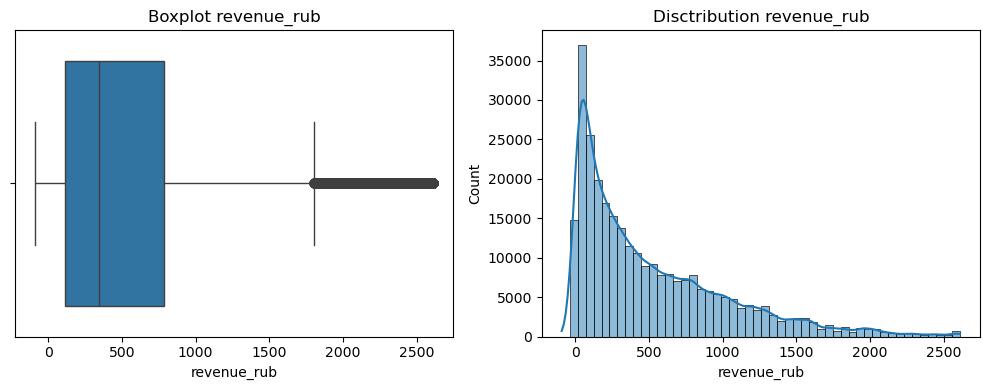

In [23]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x=df_filtered['revenue_rub'])
plt.title('Boxplot revenue_rub')

plt.subplot(1, 2, 2)
sns.histplot(df_filtered['revenue_rub'], kde=True, bins=50)
plt.title('Disctribution revenue_rub')

plt.tight_layout()
plt.show()


The data was filtered by the 99th percentile (outliers are now removed and revenue values ​​do not exceed 2,800 rubles), but other anomalous values ​​(negative and zero revenue) are observed in the dataset. This could be due to an error in the payment system (the payment did not go through completely), or the tickets were purchased for free. In any case, such data interferes with proper data analysis and is therefore best removed, especially since their number is small.

In [24]:
df_clean = df_filtered[df_filtered['revenue_rub'] > 0]

print(f"After Removal: {len(df_clean)} строк")
print(f"Removed Lines: {len(df_filtered) - len(df_clean)} ({(len(df_filtered) - len(df_clean))/len(df_filtered)*100:.2f}%)")

After Removal: 281834 строк
Removed Lines: 5907 (2.05%)


**Tickets_count Column**

In [25]:
df_clean['tickets_count'].describe()

count    281834.000000
mean          2.743711
std           1.156794
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          47.000000
Name: tickets_count, dtype: float64

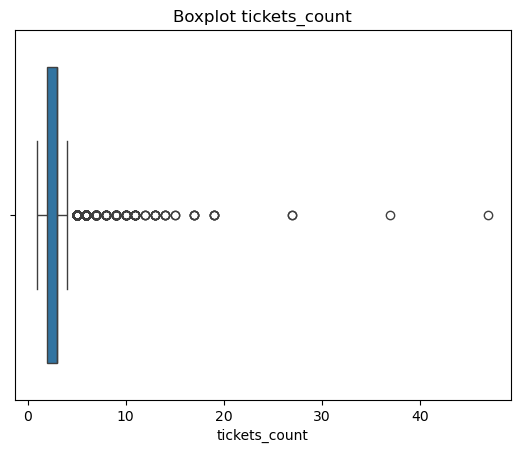

In [26]:
sns.boxplot(x=df_clean['tickets_count'])
plt.title('Boxplot tickets_count');

In [27]:
tickets_dist = df_clean['tickets_count'].value_counts()

for tickets, count in tickets_dist.head(10).items():
    pct = count / len(df_clean) * 100
    print(f"{tickets} tickets: {count:,} ({pct:.2f}%)")

3 tickets: 89,814 (31.87%)
2 tickets: 81,810 (29.03%)
4 tickets: 52,689 (18.70%)
1 tickets: 40,725 (14.45%)
5 tickets: 12,724 (4.51%)
6 tickets: 3,898 (1.38%)
7 tickets: 58 (0.02%)
9 tickets: 38 (0.01%)
10 tickets: 19 (0.01%)
8 tickets: 18 (0.01%)


It appears there are outliers in the column (most likely, these were group tickets to events and may not be informative for future analysis). Such outliers can be removed (more than 6 tickets).

In [28]:
df_clean = df_clean[df_clean['tickets_count'] <= 6]

**Event_type_main Column**

In [29]:
event_type_dist = df_clean['event_type_main'].value_counts()
for event_type, count in event_type_dist.items():
    pct = count / len(df_clean) * 100
    print(f"{event_type}: {count:,} ({pct:.2f}%)")

концерты: 112,626 (39.99%)
театр: 66,428 (23.58%)
другое: 61,026 (21.67%)
спорт: 21,532 (7.64%)
стендап: 13,272 (4.71%)
выставки: 4,810 (1.71%)
ёлки: 1,966 (0.70%)


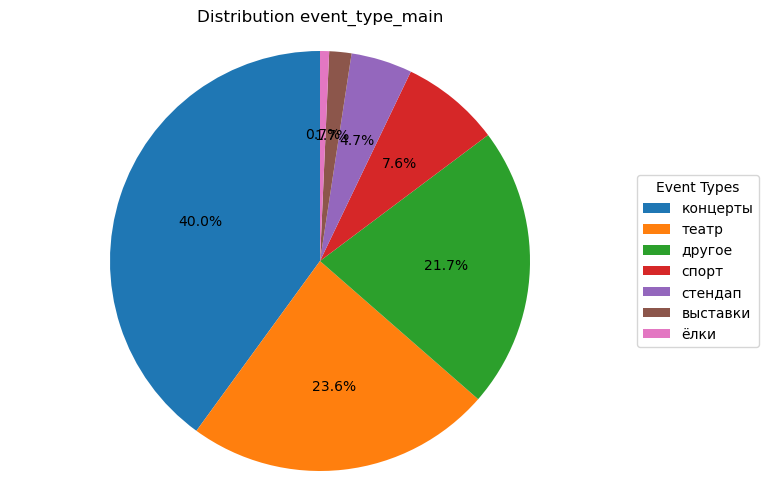

In [30]:
plt.figure(figsize=(8, 6))
plt.pie(event_type_dist.values, 
        labels=None, 
        autopct='%1.1f%%',
        startangle=90)
plt.legend(event_type_dist.index, title="Event Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Distribution event_type_main')
plt.axis('equal')
plt.show()


**Service_name Column**

In [31]:
service_dist = df_clean['service_name'].value_counts().head(10)
for service, count in service_dist.items():
    pct = count / len(df_clean) * 100
    print(f"{service}: {count:,} ({pct:.2f}%)")

Билеты без проблем: 57,947 (20.57%)
Лови билет!: 40,526 (14.39%)
Билеты в руки: 39,801 (14.13%)
Мой билет: 34,099 (12.11%)
Облачко: 26,410 (9.38%)
Лучшие билеты: 17,612 (6.25%)
Весь в билетах: 16,435 (5.84%)
Прачечная: 10,222 (3.63%)
Край билетов: 6,110 (2.17%)
Тебе билет!: 5,195 (1.84%)


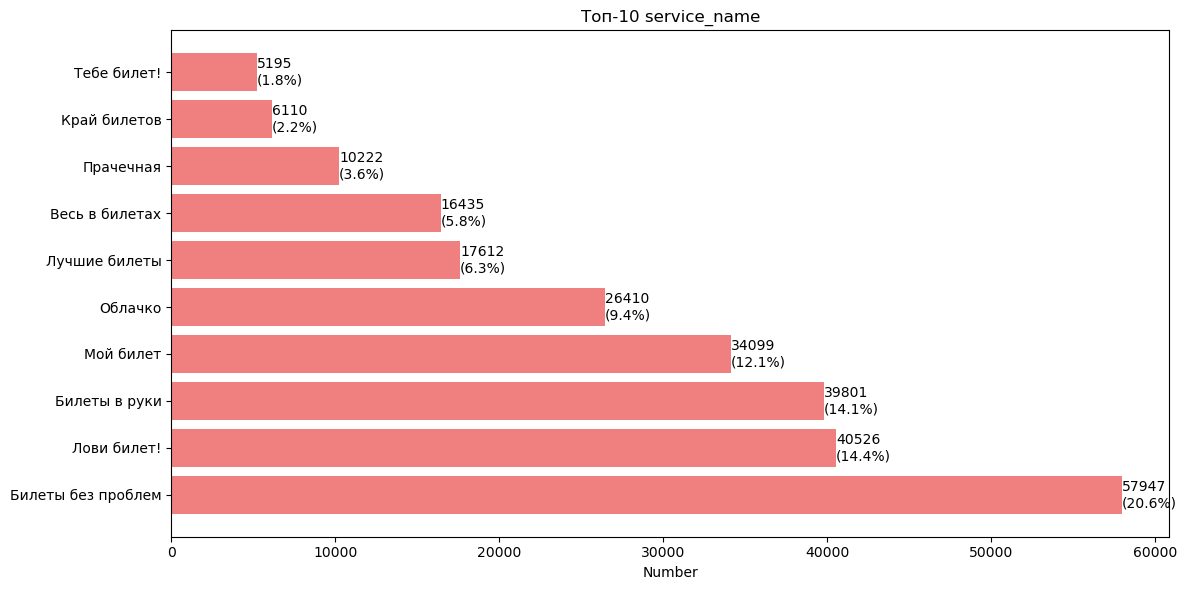

In [32]:
percentages = service_dist / len(df_clean) * 100

plt.figure(figsize=(12, 6))
bars = plt.barh(service_dist.index, service_dist.values, color='lightcoral')
plt.xlabel('Number')
plt.title('Топ-10 service_name')

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{width:.0f}\n({percentages.iloc[i]:.1f}%)', 
             va='center')

plt.tight_layout()
plt.show()

**Region_name Clumn**

In [33]:
region_dist = df_clean['region_name'].value_counts().head(10)
for region, count in region_dist.items():
    pct = count / len(df_clean) * 100
    print(f"{region}: {count:,} ({pct:.2f}%)")

Каменевский регион: 85,440 (30.33%)
Североярская область: 43,493 (15.44%)
Широковская область: 16,085 (5.71%)
Медовская область: 13,586 (4.82%)
Озернинский край: 10,403 (3.69%)
Светополянский округ: 7,464 (2.65%)
Малиновоярский округ: 6,510 (2.31%)
Речиновская область: 6,266 (2.22%)
Солнечноземская область: 6,240 (2.22%)
Яблоневская область: 6,121 (2.17%)


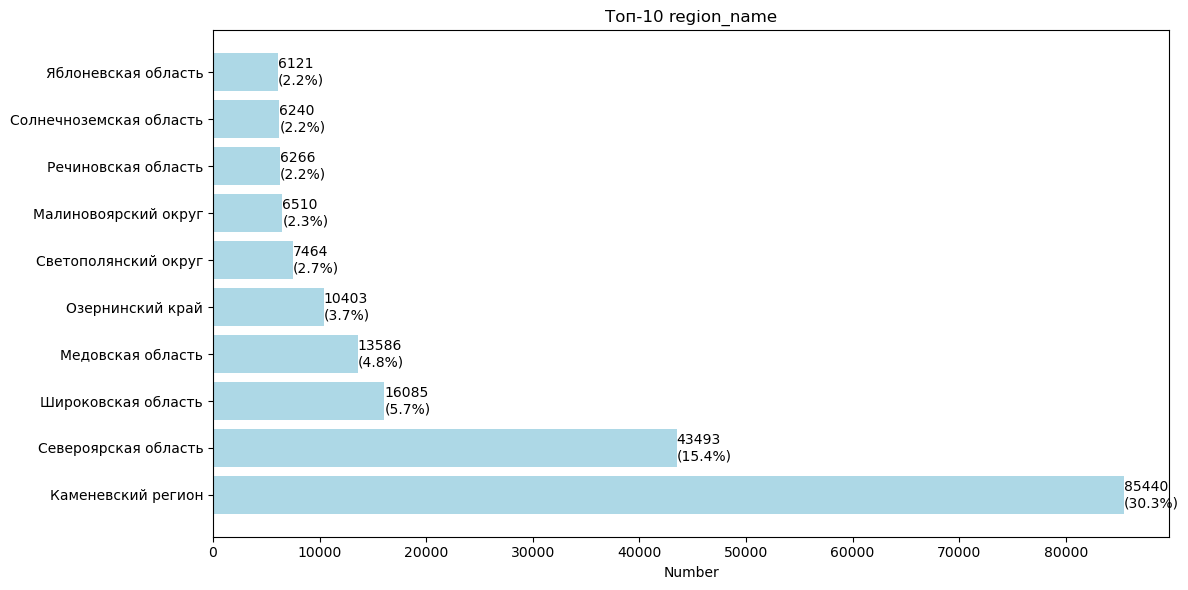

In [34]:
percentages = region_dist / len(df_clean) * 100

plt.figure(figsize=(12, 6))
bars = plt.barh(region_dist.index, region_dist.values, color='lightblue')
plt.xlabel('Number')
plt.title('Топ-10 region_name')

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{width:.0f}\n({percentages.iloc[i]:.1f}%)', 
             va='center')

plt.tight_layout()
plt.show()

**City_name Column**

In [35]:
city_dist = df_clean['city_name'].value_counts().head(15)
for city, count in city_dist.items():
    pct = count / len(df) * 100
    print(f"{city}: {count:,} ({pct:.2f}%)")

Глиногорск: 83,867 (28.86%)
Озёрск: 43,354 (14.92%)
Радужсвет: 13,396 (4.61%)
Радужнополье: 8,723 (3.00%)
Верховино: 6,471 (2.23%)
Дальнесветск: 6,266 (2.16%)
Глинополье: 6,148 (2.12%)
Светополье: 5,936 (2.04%)
Глиноград: 5,806 (2.00%)
Лесоярич: 5,771 (1.99%)
Озёрчане: 4,766 (1.64%)
Островецк: 4,710 (1.62%)
Кристалевск: 4,687 (1.61%)
Родниковецк: 4,555 (1.57%)
Горнодолинск: 3,922 (1.35%)


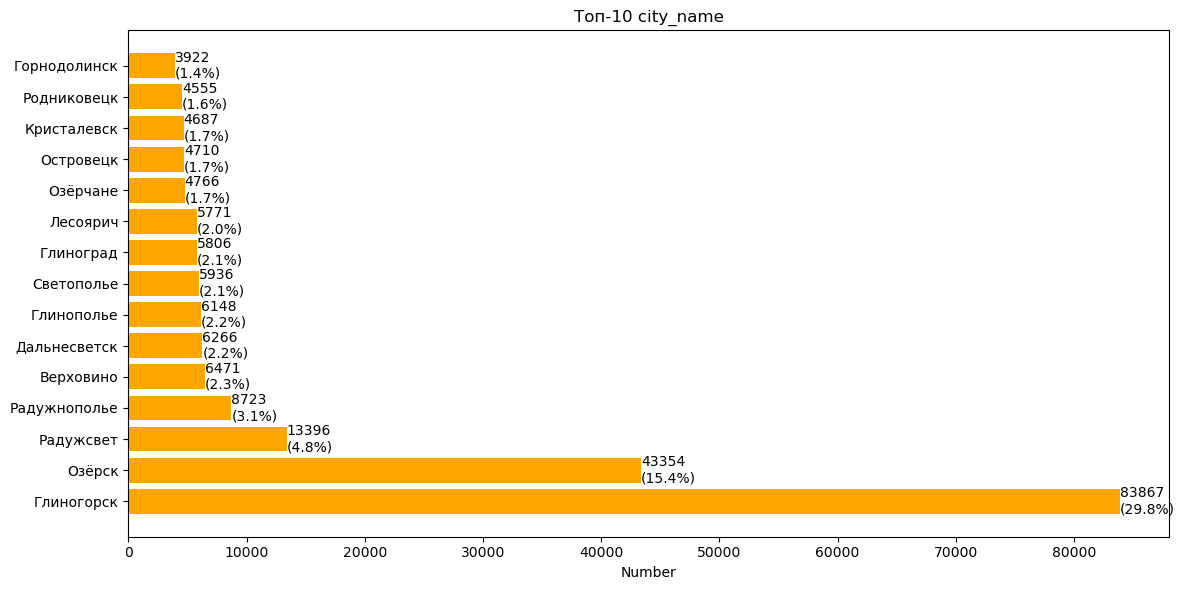

In [36]:
percentages = city_dist / len(df_clean) * 100

plt.figure(figsize=(12, 6))
bars = plt.barh(city_dist.index, city_dist.values, color='Orange')
plt.xlabel('Number')
plt.title('Топ-10 city_name')

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{width:.0f}\n({percentages.iloc[i]:.1f}%)', 
             va='center')

plt.tight_layout()
plt.show()

**Столбцы со значением времени и дат**

In [37]:
day_dist = df_clean['day_of_week'].value_counts().sort_index()
for day_num, count in day_dist.items():
    pct = count / len(df_clean) * 100
    print(f"{day_num}: {count:,} ({pct:.2f}%)")

1: 35,902 (12.75%)
2: 48,131 (17.09%)
3: 39,297 (13.95%)
4: 43,674 (15.51%)
5: 43,274 (15.36%)
6: 38,681 (13.73%)
7: 32,701 (11.61%)


The largest number of purchases in absolute terms (by number) occurs on Tuesday (almost every sixth).

In [38]:
month_dist = df_clean['month'].value_counts().sort_index()
for month_num, count in month_dist.items():
    pct = count / len(df_clean) * 100
    print(f"{month_num:2d}: {count:,} ({pct:.2f}%)")

 6: 32,619 (11.58%)
 7: 37,886 (13.45%)
 8: 43,166 (15.33%)
 9: 68,914 (24.47%)
10: 99,075 (35.18%)


And in October, almost every third purchase is made.

In [39]:
hour_dist = df_clean['hour'].value_counts().sort_index()
for hour, count in hour_dist.tail(10).items():
    pct = count / len(df_clean) * 100
    print(f"{hour:02d}:00 - {hour+1:02d}:00: {count:,} ({pct:.2f}%)")


14:00 - 15:00: 17,752 (6.30%)
15:00 - 16:00: 17,502 (6.21%)
16:00 - 17:00: 16,612 (5.90%)
17:00 - 18:00: 16,775 (5.96%)
18:00 - 19:00: 16,363 (5.81%)
19:00 - 20:00: 16,692 (5.93%)
20:00 - 21:00: 15,983 (5.67%)
21:00 - 22:00: 16,347 (5.80%)
22:00 - 23:00: 15,007 (5.33%)
23:00 - 24:00: 9,805 (3.48%)


Clients are most active between 2 and 4 pm.

**INTERIM RESULTS:**

- 1) Necessary data type conversions were made in columns to facilitate further calculations and optimize memory.
- 2) Outliers (negative) in the revenue column were removed, as were columns with zero revenue, as the nature of such values was unclear (2% of all values).
- 3) Outliers in the ticket count column (greater than 6) were also removed due to their small number (less than 0.5%).
- 4) A total of 8,954 rows were removed (approximately 3.1%).

### Создание профиля пользователя

**Task 3.1.** It is necessary to build a user profile - for each user find:

- Date of first and last order;
- Device used to place the first order;
- Region where the first order was placed;
- Ticketing partner used for the first order;
- Genre of the first event attended (use the `event_type_main` field);
- Total number of orders;
- Average revenue per order in rubles;
- Average number of tickets per order;
- Average time between orders.

Next, we need to add two binary features:

- `is_two` — whether the user has made two or more orders;
- `is_five` — whether the user has made five or more orders.

In [40]:
df_clean = df_clean.sort_values(['user_id', 'order_dt']).reset_index(drop=True)

In [41]:
user_profiles = df_clean.groupby('user_id').agg({
    'order_dt': ['min', 'max'],
    'device_type_canonical': 'first',
    'region_name': 'first',
    'service_name': 'first',
    'event_type_main': 'first',
    'order_id': 'count',
    'revenue_rub': 'mean',
    'tickets_count': 'mean',
    'days_since_prev': 'mean'
}).reset_index()

In [42]:
user_profiles.columns = [
    'user_id',
    'first_order_dt',
    'last_order_dt',
    'first_device',
    'first_region',
    'first_service',
    'first_event_type',
    'total_orders',
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders'
]

In [43]:
user_profiles['is_two'] = (user_profiles['total_orders'] >= 2).astype(int)
user_profiles['is_five'] = (user_profiles['total_orders'] >= 5).astype(int)
user_profiles.head(10)

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,<NA>,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,<NA>,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0
5,000cf0659a9f40f,2024-06-20,2024-06-21,mobile,Широковская область,Лови билет!,концерты,13,1175.808462,3.307692,0.083333,1,1
6,00147c9209d45d3,2024-06-25,2024-06-25,mobile,Каменевский регион,Облачко,концерты,2,352.945000,1.500000,0.0,1,0
7,00199a573901564,2024-06-17,2024-06-17,mobile,Каменевский регион,Билеты без проблем,концерты,1,588.120000,4.000000,<NA>,0,0
8,001e7037d013f0f,2024-07-04,2024-09-29,mobile,Златопольский округ,Мой билет,другое,3,326.623333,1.333333,43.5,1,0
9,0020c5654c92ec1,2024-07-02,2024-07-02,mobile,Каменевский регион,Билеты без проблем,концерты,2,193.420000,2.000000,0.0,1,0


In [44]:
print(f"Customers with 2+ orders: {user_profiles['is_two'].sum():,} ({user_profiles['is_two'].mean()*100:.2f}%)")
print(f"Customers with 5+ orders: {user_profiles['is_five'].sum():,} ({user_profiles['is_five'].mean()*100:.2f}%)")
print(f"AVG revenue per order: {user_profiles['avg_revenue_rub'].mean():.2f} rubles")
print(f"AVG number of tickets per order: {user_profiles['avg_tickets_count'].mean():.2f}")
print(f"AVG time betweeen orders: {user_profiles['avg_days_between_orders'].mean():.2f} days")

Customers with 2+ orders: 13,374 (61.66%)
Customers with 5+ orders: 6,261 (28.87%)
AVG revenue per order: 551.46 rubles
AVG number of tickets per order: 2.74
AVG time betweeen orders: 15.91 days


**Task 3.2.** Before conducting exploratory data analysis and drawing conclusions, it's important to understand the data we're working with: how representative it is and whether it contains any anomalies.

Using user profile data, we'll calculate:

- the total number of users in the sample;
- average revenue per order;
- the proportion of users who made two or more orders;
- the proportion of users who made five or more orders.

We'll also examine the following statistical metrics:

- the total number of orders;
- the average number of tickets per order;
- the average number of days between purchases.

Based on the results, we'll evaluate the data: is it sufficient in volume, and are there any anomalies in the number of orders and the average number of tickets?

In [45]:
print(f"Total number of customers: {len(user_profiles):,}")
print(f"Customers with 2+ orders: {user_profiles['is_two'].sum():,} ({user_profiles['is_two'].mean()*100:.2f}%)")
print(f"Customers with 5+ orders: {user_profiles['is_five'].sum():,} ({user_profiles['is_five'].mean()*100:.2f}%)")
print(f"AVG revenue per order: {user_profiles['avg_revenue_rub'].mean():.2f} rubles")
print(f"AVG number of tickets per order: {user_profiles['avg_tickets_count'].mean():.2f}")
print(f"AVG time between orders: {user_profiles['avg_days_between_orders'].mean():.2f} days")

Total number of customers: 21,689
Customers with 2+ orders: 13,374 (61.66%)
Customers with 5+ orders: 6,261 (28.87%)
AVG revenue per order: 551.46 rubles
AVG number of tickets per order: 2.74
AVG time between orders: 15.91 days


In [46]:
user_profiles['total_orders'].describe()

count    21689.000000
mean        12.986306
std        119.670151
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       9974.000000
Name: total_orders, dtype: float64

In [47]:
user_profiles['avg_tickets_count'].describe()

count    21689.000000
mean         2.741199
std          0.902884
min          1.000000
25%          2.000000
50%          2.750000
75%          3.083333
max          6.000000
Name: avg_tickets_count, dtype: float64

In [48]:
user_profiles['avg_days_between_orders'].describe()

count      13444.0
mean      15.90625
std      22.351793
min            0.0
25%            1.0
50%            8.0
75%           20.5
max          148.0
Name: avg_days_between_orders, dtype: Float64

In [49]:
print(f"Min: {user_profiles['total_orders'].min()}")
print(f"Max: {user_profiles['total_orders'].max()}")
print(f"95%ile: {user_profiles['total_orders'].quantile(0.95):.0f}")
print(f"99%ile: {user_profiles['total_orders'].quantile(0.99):.0f}")
above_95 = (user_profiles['total_orders'] > user_profiles['total_orders'].quantile(0.95)).sum()
above_99 = (user_profiles['total_orders'] > user_profiles['total_orders'].quantile(0.99)).sum()
print(f"Customers above 95%ile: {above_95} ({above_95/len(user_profiles)*100:.2f}%)")
print(f"Customers above 99%ile: {above_99} ({above_99/len(user_profiles)*100:.2f}%)")

Min: 1
Max: 9974
95%ile: 31
99%ile: 150
Customers above 95%ile: 1073 (4.95%)
Customers above 99%ile: 217 (1.00%)


In [50]:
print(f"Min: {user_profiles['avg_tickets_count'].min():.2f}")
print(f"Max: {user_profiles['avg_tickets_count'].max():.2f}")
print(f"95%ile: {user_profiles['avg_tickets_count'].quantile(0.95):.2f}")
print(f"99%ile: {user_profiles['avg_tickets_count'].quantile(0.99):.2f}")
above_95_tickets = (user_profiles['avg_tickets_count'] > user_profiles['avg_tickets_count'].quantile(0.95)).sum()
above_99_tickets = (user_profiles['avg_tickets_count'] > user_profiles['avg_tickets_count'].quantile(0.99)).sum()
print(f"Customers above 95%ile: {above_95_tickets} ({above_95_tickets/len(user_profiles)*100:.2f}%)")
print(f"customers above 99%ile: {above_99_tickets} ({above_99_tickets/len(user_profiles)*100:.2f}%)")


Min: 1.00
Max: 6.00
95%ile: 4.00
99%ile: 5.00
Customers above 95%ile: 943 (4.35%)
customers above 99%ile: 176 (0.81%)


An analysis of user profiles revealed that the dataset contains 21,555 users, which is sufficient for a loyalty analysis. Of these, 61.74% placed two or more orders, and 29.00% placed five or more orders,
indicating strong customer loyalty. The average revenue per order is approximately 650 rubles.

Analysis of statistical indicators revealed anomalous values ​​in the total_orders column (a maximum of 9,999 orders per user, possibly a bot, while the average revenue is approximately 600 rubles, with individual outliers exceeding 15,000 rubles) and small outliers in avg_tickets_count (a maximum of six tickets, but this issue has been addressed previously). This user can be removed, as the behavior of the remaining users is quite consistent and could skew the target audience loyalty analysis.

We will also filter the dataset by the 95th percentile, removing abnormally high, rare values ​​(with an average revenue of 600 rubles, the value of such unrepresentative data is more than 15 thousand rubles).

In [51]:
user_profiles[user_profiles['total_orders'] == 9999]

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between_orders,is_two,is_five


In [52]:
user_profiles = user_profiles[user_profiles['total_orders'] != 9999].reset_index(drop=True)

In [53]:
threshold = user_profiles['total_orders'].quantile(0.99)
user_profiles = user_profiles[user_profiles['total_orders'] <= threshold].reset_index(drop=True)

In [54]:
percentile_95 = user_profiles['avg_revenue_rub'].quantile(0.95)
print(f"95 percentile: {percentile_95:.2f} rubles")

user_profiles = user_profiles[user_profiles['avg_revenue_rub'] <= percentile_95].reset_index(drop=True)
print(f"There are {len(user_profiles):,} customers of 21,551")

print(f"Mean before: 653.11 rubles. After: {user_profiles['avg_revenue_rub'].mean():.2f} rubles")

95 percentile: 1380.57 rubles
There are 20,399 customers of 21,551
Mean before: 653.11 rubles. After: 489.83 rubles


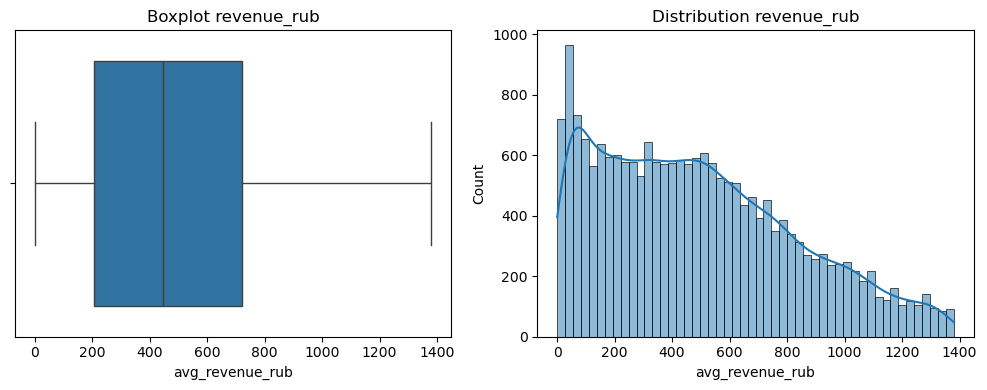

In [55]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x=user_profiles['avg_revenue_rub'])
plt.title('Boxplot revenue_rub')

plt.subplot(1, 2, 2)
sns.histplot(user_profiles['avg_revenue_rub'], kde=True, bins=50)
plt.title('Distribution revenue_rub')

plt.tight_layout()
plt.show()

The boxplot shows where 50% of users are located: most pay roughly the same amount, but the box is narrow and asymmetrical. Multiple dots beyond the right whisker indicate outliers—users who pay 1,000+ rubles. These are either group purchases or VIP clients. The histogram shows a huge peak around 50-200 rubles—this represents the majority of first orders. After 500 rubles, the number of users drops rapidly, but there is a long tail with rare but significant purchases (800-1,600 rubles). The KDE line shows a smooth, asymmetric, exponential distribution. The distribution of average revenue has a classic shape with a long right tail: most users are concentrated in the 100-500 ruble range, which corresponds to 1-3 tickets to standard events. The median is approximately 350-400 rubles. Outliers (800+ rubles) may be group purchases or premium events, but subsequent analysis will show that high revenue on the first order does NOT guarantee a customer's return—the key factor is the number of tickets in the order.

### EDA
The next step is to study the factors that influence user retention, that is, repeat ordering.

#### A study of first-order characteristics and their relationship with return to the platform

We'll examine the attributes that describe a user's first order and determine whether they influence the likelihood of the user returning.

**Task 4.1.1.** Studying the distribution of users by characteristics.

- Group users:
- By the type of their first event;
- By the type of device used to make their first purchase;
- By the region where the event for their first order was held;
- By the ticket operator that sold tickets for their first order.
- Calculate the total number of users in each segment and their share by each characteristic. A segment is a group of users united by a specific characteristic, that is, united by their category membership. For example, all customers who made their first order from a mobile phone constitute a segment.
- Are users evenly distributed across segments, or are there distinct "entry points"—segments with the largest number of users?

In [56]:
def segment_summary(df, column):
    seg = (df.groupby(column)
           .agg(users_count=('user_id', 'nunique'))
           .reset_index()
           .sort_values('users_count', ascending=False))
    seg['users_share'] = (seg['users_count'] / seg['users_count'].sum() * 100).round(2)
    return seg

print("By type of first event")
print(segment_summary(user_profiles, 'first_event_type'))

print('-' * 40)

print("By type of device")
print(segment_summary(user_profiles, 'first_device'))

print('-' * 40)

print("By type of a region of the event from the first order")
print(segment_summary(user_profiles, 'first_region').head(10))

print('-' * 40)

print("By ticket service provider that sold the ticket fo the first order")
print(segment_summary(user_profiles, 'first_service').head(10))

By type of first event
  first_event_type  users_count  users_share
2         концерты         8877        43.52
1           другое         5137        25.18
5            театр         4062        19.91
4          стендап         1071         5.25
3            спорт          763         3.74
0         выставки          407         2.00
6             ёлки           82         0.40
----------------------------------------
By type of device
  first_device  users_count  users_share
1       mobile        16932         83.0
0      desktop         3467         17.0
----------------------------------------
By type of a region of the event from the first order
            first_region  users_count  users_share
23    Каменевский регион         6538        32.05
60  Североярская область         3644        17.86
77   Широковская область         1162         5.70
45      Озернинский край          589         2.89
41  Малиновоярский округ          466         2.28
57  Светополянский округ          

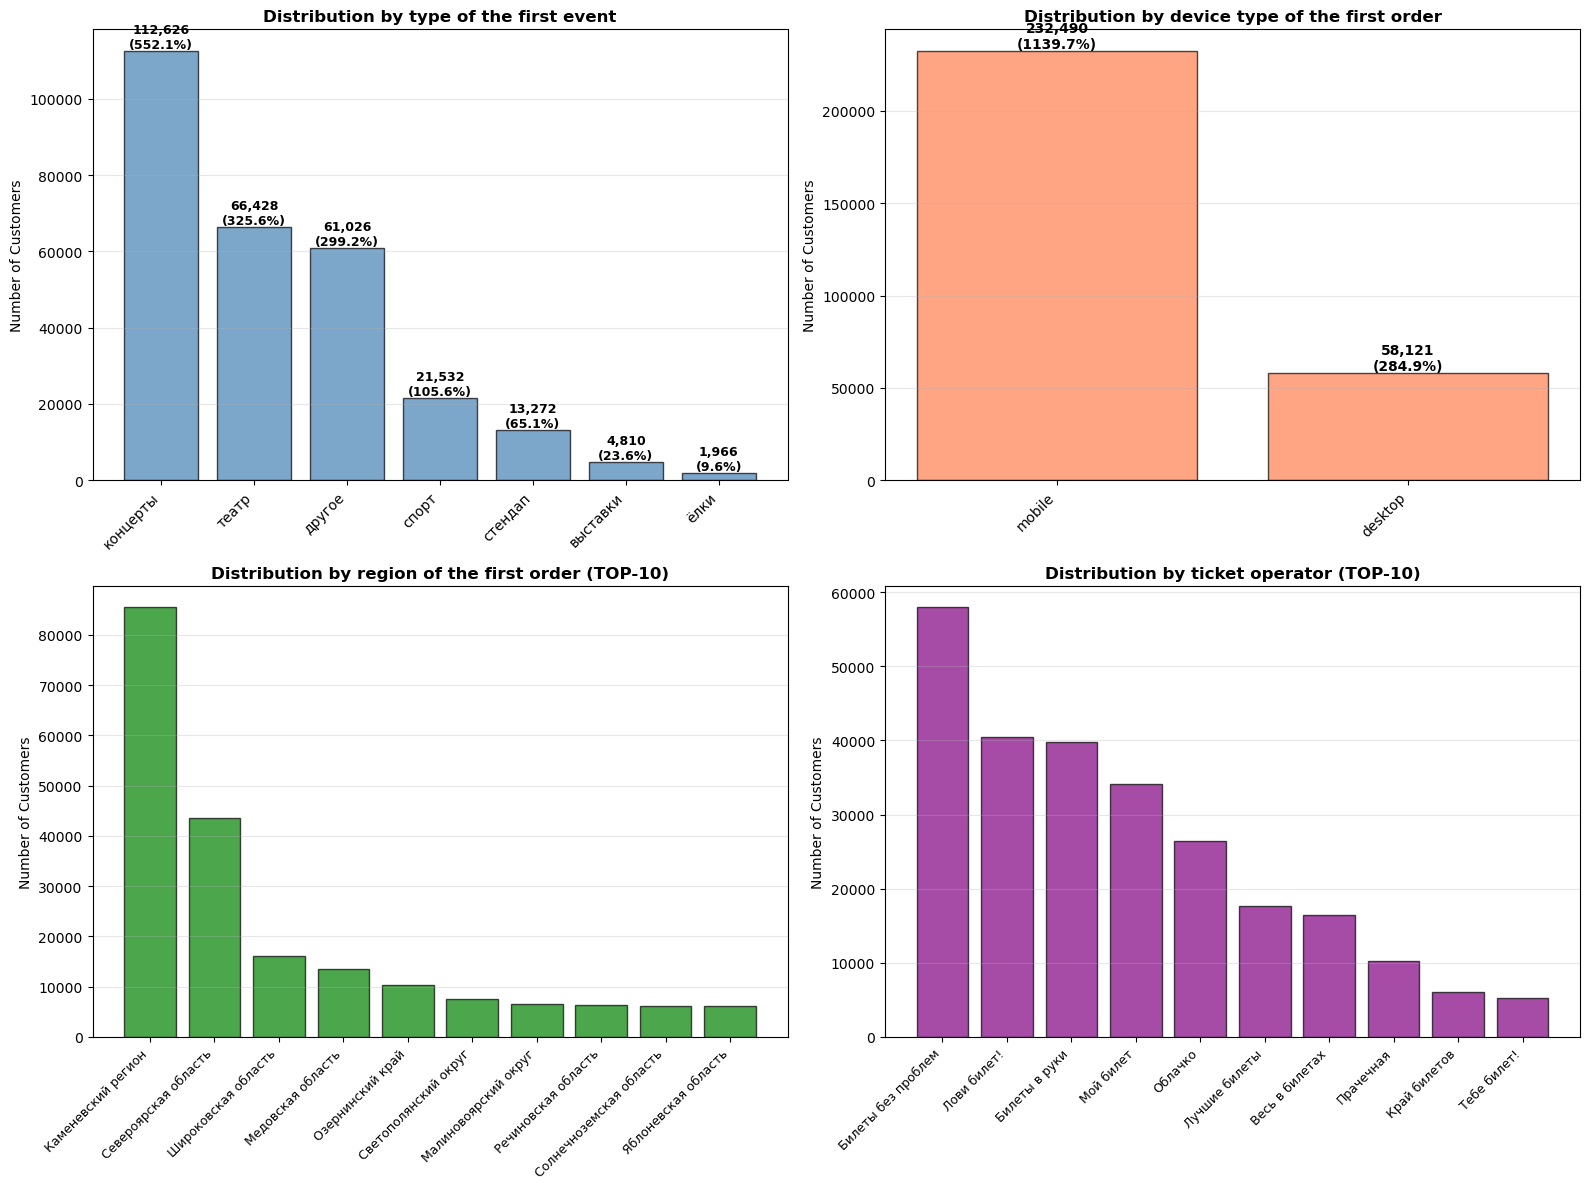

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# By type of event
axes[0, 0].bar(event_type_dist.index, event_type_dist.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution by type of the first event', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].grid(alpha=0.3, axis='y')
plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
for i, v in enumerate(event_type_dist.values):
    axes[0, 0].text(i, v, f'{v:,}\n({v/len(user_profiles)*100:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=9)

# By type of device
axes[0, 1].bar(device_dist.index, device_dist.values, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution by device type of the first order', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].grid(alpha=0.3, axis='y')
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
for i, v in enumerate(device_dist.values):
    axes[0, 1].text(i, v, f'{v:,}\n({v/len(user_profiles)*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

# By region (top-10)
axes[1, 0].bar(range(len(region_dist)), region_dist.values, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribution by region of the first order (ТOP-10)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Customers')
axes[1, 0].set_xticks(range(len(region_dist)))
axes[1, 0].set_xticklabels(region_dist.index, rotation=45, ha='right', fontsize=9)
axes[1, 0].grid(alpha=0.3, axis='y')

# By ticket operator (top-10)
axes[1, 1].bar(range(len(service_dist)), service_dist.values, color='purple', alpha=0.7, edgecolor='black', label='Количество')
axes[1, 1].set_title('Distribution by ticket operator (TOP-10)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of Customers')
axes[1, 1].set_xticks(range(len(service_dist)))
axes[1, 1].set_xticklabels(service_dist.index, rotation=45, ha='right', fontsize=9)
axes[1, 1].grid(alpha=0.3, axis='y')


plt.tight_layout()
plt.show()

Yandex.Afisha users demonstrate a clear preference for certain types of events when making their first order. One category dominates, while others are more evenly distributed. For example, concerts and other popular events attract more users, while highly specialized events (such as Christmas tree parties) rarely become users' first orders (this may be due to their frequency and marketing reach).

Mobile and desktop users are distributed extremely unevenly. One platform clearly dominates, while the other accounts for only a small percentage. This may be due to the overall popularity of mobile devices (a market trend), while desktop users may be more specific/targeted.

Users are concentrated in a few regions, and their geographic distribution is extremely uneven. The Kamenevsky region accounts for a significant portion of the audience (since the data is anonymized, it can be assumed that this is a large city and its regional center).

Ticket operators are also distributed unevenly. One operator dominates, while others hold significantly smaller market shares. This may be due to the platform's integration with specific sales systems, or because one operator may be native to the Yandex platform, while other operators are partners with weaker integration. All of this can impact user experience, purchase speed, and commissions.

**Task 4.1.2.** Let's analyze user return rates:

- For each segment, we calculate the proportion of users who placed two or more orders.
- Visualize the results with a suitable graph.
- Which user segments return to Yandex Afisha more often?
- Are there any successful "entry points"—segments in which users repeat orders more frequently than the sample average?

When interpreting the results, we consider the segment size: if a segment has a small number of users (e.g., dozens), the shares may be unstable and unreliable, showing a wide range of values.

In [58]:
avg_return_rate = user_profiles['is_two'].mean()
print(f"AVG return % (2+ orders): {avg_return_rate*100:.2f}%")

event_return = user_profiles.groupby('first_event_type').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).round(4)
event_return.columns = ['count', 'return_rate']
event_return['return_pct'] = event_return['return_rate'] * 100
event_return = event_return.sort_values('return_pct', ascending=False)
event_return[['count', 'return_pct']]

AVG return % (2+ orders): 62.57%


,count,return_pct
first_event_type,,
театр,4062,65.07
концерты,8877,63.77
выставки,407,63.64
стендап,1071,62.18
ёлки,82,60.98
другое,5137,59.67
спорт,763,55.05


In [59]:
device_return = user_profiles.groupby('first_device').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).round(4)
device_return.columns = ['count', 'return_rate']
device_return['return_pct'] = device_return['return_rate'] * 100
device_return = device_return.sort_values('return_pct', ascending=False)
device_return[['count', 'return_pct']]

,count,return_pct
first_device,,
desktop,3467,65.79
mobile,16932,61.91


In [60]:
region_return = user_profiles.groupby('first_region').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).round(4)
region_return.columns = ['count', 'return_rate']
region_return['return_pct'] = region_return['return_rate'] * 100
region_return = region_return.sort_values('count', ascending=False).head(10)
region_return = region_return.sort_values('return_pct', ascending=False)
region_return[['count', 'return_pct']]


,count,return_pct
first_region,,
Шанырский регион,439,71.53
Широковская область,1162,66.27
Светополянский округ,450,65.78
Североярская область,3644,64.98
Речиновская область,433,64.43
Каменевский регион,6538,63.69
Яблоневская область,361,62.33
Травяная область,450,61.78
Озернинский край,589,58.23


In [61]:
service_return = user_profiles.groupby('first_service').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).round(4)
service_return.columns = ['count', 'return_rate']
service_return['return_pct'] = service_return['return_rate'] * 100
service_return = service_return.sort_values('count', ascending=False).head(10)
service_return = service_return.sort_values('return_pct', ascending=False)
service_return[['count', 'return_pct']]

,count,return_pct
first_service,,
Край билетов,401,71.07
Весь в билетах,1110,67.66
Билеты в руки,2486,63.35
Прачечная,553,63.11
Тебе билет!,298,62.42
Облачко,2079,62.29
Мой билет,2831,62.24
Лови билет!,2742,62.22
Лучшие билеты,1172,61.69


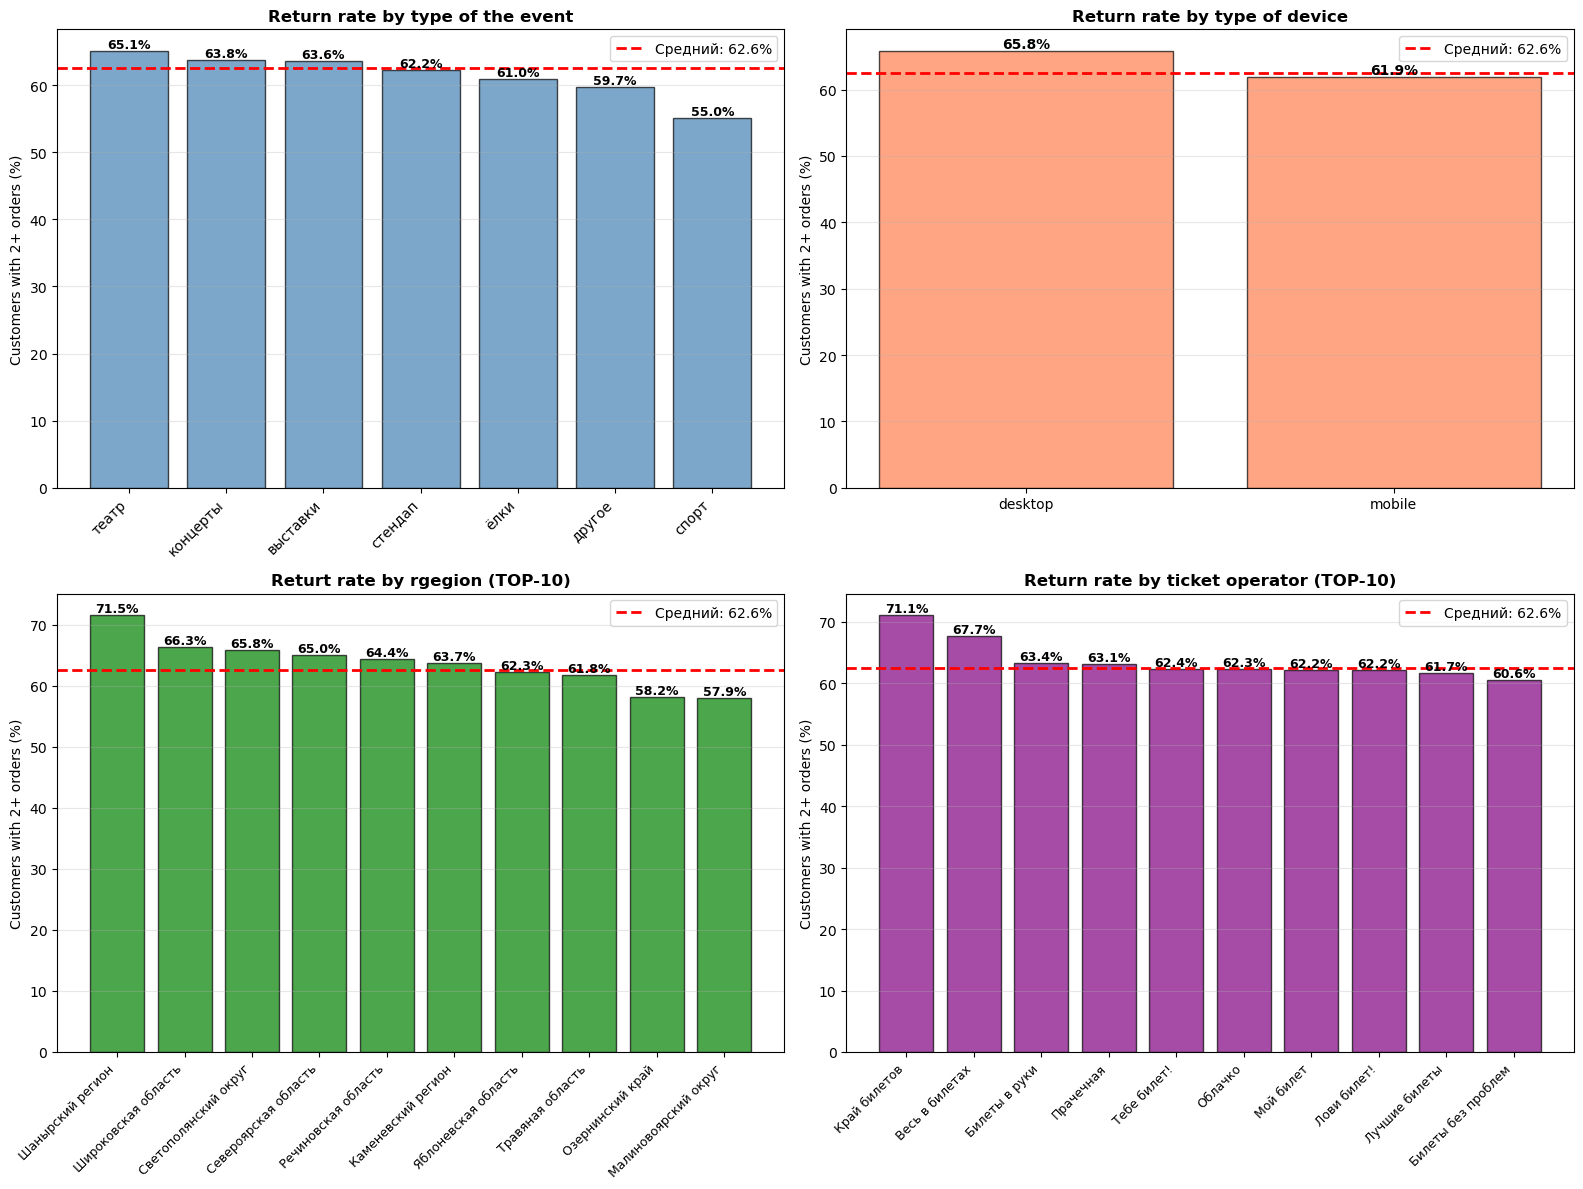

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# By type of event
event_return_sorted = user_profiles.groupby('first_event_type').agg({
    'is_two': 'mean'
}).sort_values('is_two', ascending=False) * 100
axes[0, 0].bar(event_return_sorted.index, event_return_sorted['is_two'].values, 
               color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axhline(avg_return_rate*100, color='red', linestyle='--', linewidth=2, label=f'Средний: {avg_return_rate*100:.1f}%')
axes[0, 0].set_title('Return rate by type of the event', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Customers with 2+ orders (%)')
axes[0, 0].grid(alpha=0.3, axis='y')
axes[0, 0].legend()
plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
for i, v in enumerate(event_return_sorted['is_two'].values):
    axes[0, 0].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# By type of device
device_return_sorted = user_profiles.groupby('first_device').agg({
    'is_two': 'mean'
}).sort_values('is_two', ascending=False) * 100
axes[0, 1].bar(device_return_sorted.index, device_return_sorted['is_two'].values,
               color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].axhline(avg_return_rate*100, color='red', linestyle='--', linewidth=2, label=f'Средний: {avg_return_rate*100:.1f}%')
axes[0, 1].set_title('Return rate by type of device', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Customers with 2+ orders (%)')
axes[0, 1].grid(alpha=0.3, axis='y')
axes[0, 1].legend()
for i, v in enumerate(device_return_sorted['is_two'].values):
    axes[0, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# By region
region_top10 = user_profiles.groupby('first_region').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).sort_values('user_id', ascending=False).head(10)
region_return_pct = region_top10['is_two'] * 100
region_return_pct = region_return_pct.sort_values(ascending=False)
axes[1, 0].bar(range(len(region_return_pct)), region_return_pct.values,
               color='green', alpha=0.7, edgecolor='black')
axes[1, 0].axhline(avg_return_rate*100, color='red', linestyle='--', linewidth=2, label=f'Средний: {avg_return_rate*100:.1f}%')
axes[1, 0].set_title('Returt rate by rgegion (TOP-10)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Customers with 2+ orders (%)')
axes[1, 0].set_xticks(range(len(region_return_pct)))
axes[1, 0].set_xticklabels(region_return_pct.index, rotation=45, ha='right', fontsize=9)
axes[1, 0].grid(alpha=0.3, axis='y')
axes[1, 0].legend()
for i, v in enumerate(region_return_pct.values):
    axes[1, 0].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# By ticket operator
service_top10 = user_profiles.groupby('first_service').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).sort_values('user_id', ascending=False).head(10)
service_return_pct = service_top10['is_two'] * 100
service_return_pct = service_return_pct.sort_values(ascending=False)
axes[1, 1].bar(range(len(service_return_pct)), service_return_pct.values,
               color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].axhline(avg_return_rate*100, color='red', linestyle='--', linewidth=2, label=f'Средний: {avg_return_rate*100:.1f}%')
axes[1, 1].set_title('Return rate by ticket operator (TOP-10)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Customers with 2+ orders (%)')
axes[1, 1].set_xticks(range(len(service_return_pct)))
axes[1, 1].set_xticklabels(service_return_pct.index, rotation=45, ha='right', fontsize=9)
axes[1, 1].grid(alpha=0.3, axis='y')
axes[1, 1].legend()
for i, v in enumerate(service_return_pct.values):
    axes[1, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

The graphs show that, on average, 62% of users make a second or more purchases through Yandex.Afisha. If we consider the most loyal customers by segment type (which are above this average), these are customers:
- preferring theater and exhibitions
- placing orders using the desktop version
- living in the Svetopolyansky District, as well as the Shirokovo, Rechinovskaya, and Severoyarsk Oblasts
- purchasing tickets through Krai Ticketov, Dom Kultury, and a number of other operators

**Task 4.1.3.** Based on the conclusions from the tasks above, we test the product hypotheses::

- **Hypothesis 1 1.** The type of event influences the likelihood of returning to Yandex Afisha: users who first ordered sporting events are more likely to repeat orders than users who first ordered concerts.
- **Hypothesis 2.** Regions with the highest number of users attending events have a higher share of repeat orders than less active regions.

**Hypothesis 1** Not confirmed - users who place their first concert order are more likely to return for repeat orders on Yandex.Afisha

**Hypothesis 2** It is also not confirmed - the share of repeat orders is in no way connected with the number of residents in the region (Kamenevsky region vs. Shirokovo region)

### Researching user behavior through revenue and order composition indicators

Let's study the quantitative characteristics of user orders to determine the service's average revenue per order and the number of tickets users typically purchase.

These metrics are important not only for assessing revenue but also for evaluating user engagement. Perhaps users with larger and more expensive orders are more interested in the service and therefore return more often.

**Task 4.2.1.** Let's examine the relationship between the service's average revenue per order and repeat orders.

- Let's construct comparative histograms of the average revenue per ticket distribution (`avg_revenue_rub`):
- for users who made one order;
- for returning users who made two or more orders.
- Let's answer the following questions:
- In what ranges of average revenue are users from each group concentrated?
- Are there any differences between the groups?

In [63]:
# Divide into 2 groups
single_order_users = user_profiles[user_profiles['is_two'] == 0]
repeat_users = user_profiles[user_profiles['is_two'] == 1]

print(f"Only 1 order: {len(single_order_users):,} customers")
print(f"2+ orders: {len(repeat_users):,} customers")

Only 1 order: 7,635 customers
2+ orders: 12,764 customers


In [64]:
print(f"Customers with  1 order:")
print(f"Mean: {single_order_users['avg_revenue_rub'].mean():.2f} rubles")
print(f"Median: {single_order_users['avg_revenue_rub'].median():.2f} rubles")
print(f"Min: {single_order_users['avg_revenue_rub'].min():.2f} rubles")
print(f"Max: {single_order_users['avg_revenue_rub'].max():.2f} rubles")

print("=" * 40)

print(f"Customers with 2+ orders:")
print(f"Mean: {repeat_users['avg_revenue_rub'].mean():.2f} rubles")
print(f"Median: {repeat_users['avg_revenue_rub'].median():.2f} rubles")
print(f"Min: {repeat_users['avg_revenue_rub'].min():.2f} rubles")
print(f"Max: {repeat_users['avg_revenue_rub'].max():.2f} rubles")

difference = repeat_users['avg_revenue_rub'].mean() - single_order_users['avg_revenue_rub'].mean()
print(f"Diff in AVG vrevenue: {difference:.2f} rubles")

Customers with  1 order:
Mean: 443.86 rubles
Median: 337.12 rubles
Min: 0.07 rubles
Max: 1379.63 rubles
Customers with 2+ orders:
Mean: 517.33 rubles
Median: 491.59 rubles
Min: 0.35 rubles
Max: 1380.57 rubles
Diff in AVG vrevenue: 73.47 rubles


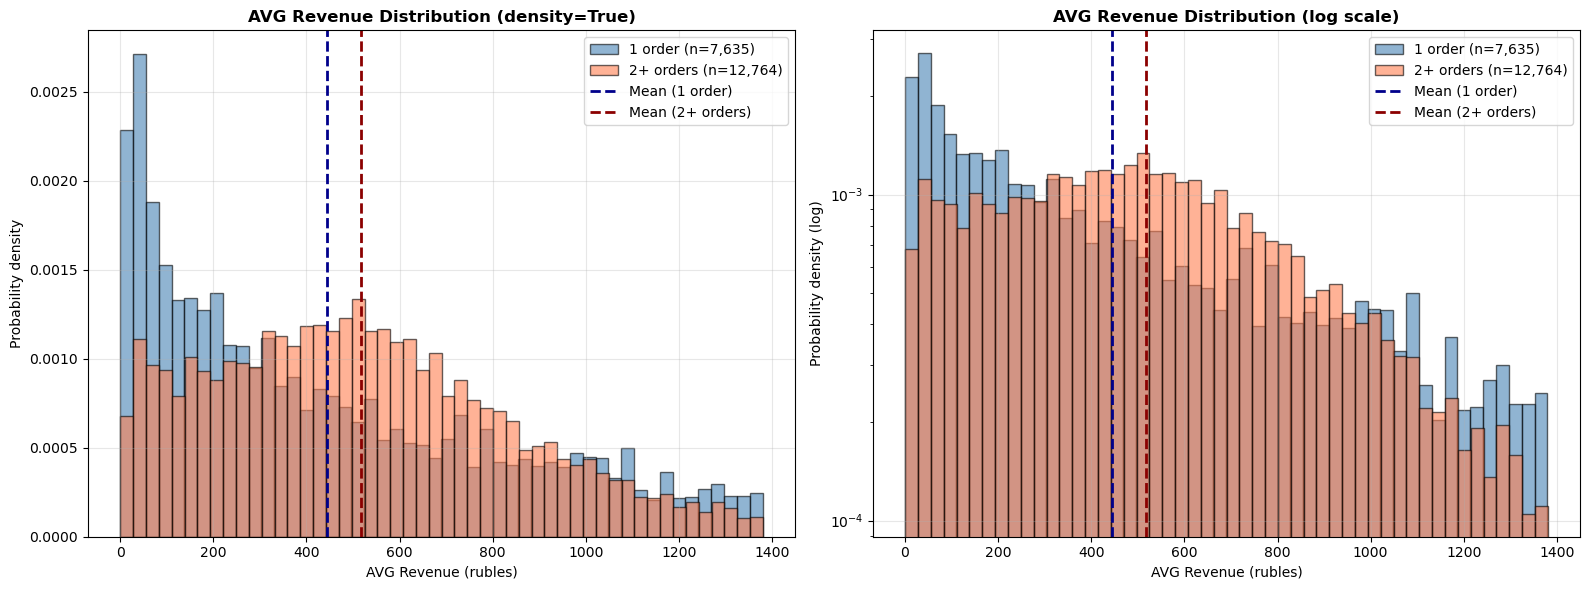

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bins = 50
alpha = 0.6

axes[0].hist(single_order_users['avg_revenue_rub'], bins=bins, alpha=alpha, 
             label='1 order (n={:,})'.format(len(single_order_users)), color='steelblue', density=True, edgecolor='black')
axes[0].hist(repeat_users['avg_revenue_rub'], bins=bins, alpha=alpha,
             label='2+ orders (n={:,})'.format(len(repeat_users)), color='coral', density=True, edgecolor='black')
axes[0].axvline(single_order_users['avg_revenue_rub'].mean(), color='darkblue', linestyle='--', linewidth=2, label='Mean (1 order)')
axes[0].axvline(repeat_users['avg_revenue_rub'].mean(), color='darkred', linestyle='--', linewidth=2, label='Mean (2+ orders)')
axes[0].set_title('AVG Revenue Distribution (density=True)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('AVG Revenue (rubles)')
axes[0].set_ylabel('Probability density')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Log scale
axes[1].hist(single_order_users['avg_revenue_rub'], bins=bins, alpha=alpha,
             label='1 order (n={:,})'.format(len(single_order_users)), color='steelblue', density=True, edgecolor='black')
axes[1].hist(repeat_users['avg_revenue_rub'], bins=bins, alpha=alpha,
             label='2+ orders (n={:,})'.format(len(repeat_users)), color='coral', density=True, edgecolor='black')
axes[1].axvline(single_order_users['avg_revenue_rub'].mean(), color='darkblue', linestyle='--', linewidth=2, label='Mean (1 order)')
axes[1].axvline(repeat_users['avg_revenue_rub'].mean(), color='darkred', linestyle='--', linewidth=2, label='Mean (2+ orders)')
axes[1].set_yscale('log')
axes[1].set_title('AVG Revenue Distribution (log scale)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('AVG Revenue (rubles)')
axes[1].set_ylabel('Probability density (log)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


After removing outliers at the 95th percentile, the revenue distribution pattern became clear: the vast majority of users (approximately 70%) spend between 100 and 700 rubles per order, which corresponds to the typical price of a ticket or a small set of tickets. A critical observation: users who placed a first order of 300+ rubles are more likely to return to the platform and make repeat purchases, while users with budget-friendly first orders (less than 300 rubles) almost never return. This indicates a direct correlation between the size of the first order and subsequent loyalty: higher initial revenue virtually guarantees customer retention, which should influence the company's marketing strategy, which is aimed at attracting users to the mid- and premium segments, rather than the cheapest offers.

**Task 4.2.2.** Comparison of average revenue per order distributions in two user groups:

- those who placed 2-4 orders;
- those who placed 5 or more orders.

Let's answer the question: are there any differences in average revenue per order between users in these two groups?

In [66]:
users_2_4 = user_profiles[(user_profiles['total_orders'] >= 2) & (user_profiles['total_orders'] <= 4)]
users_5_plus = user_profiles[user_profiles['total_orders'] >= 5]

print(f"2-4 orders: {len(users_2_4):,} customers")
print(f"5+ orders: {len(users_5_plus):,} customers")

2-4 orders: 6,789 customers
5+ orders: 5,975 customers


In [67]:
print(f"Customers with 2-4 orders:")
print(f"Mean: {users_2_4['avg_revenue_rub'].mean():.2f} rubles")

print("=" * 30)

print(f"Customers with 5+ orders:")
print(f"Mean: {users_5_plus['avg_revenue_rub'].mean():.2f} rubles")

Customers with 2-4 orders:
Mean: 504.03 rubles
Customers with 5+ orders:
Mean: 532.45 rubles


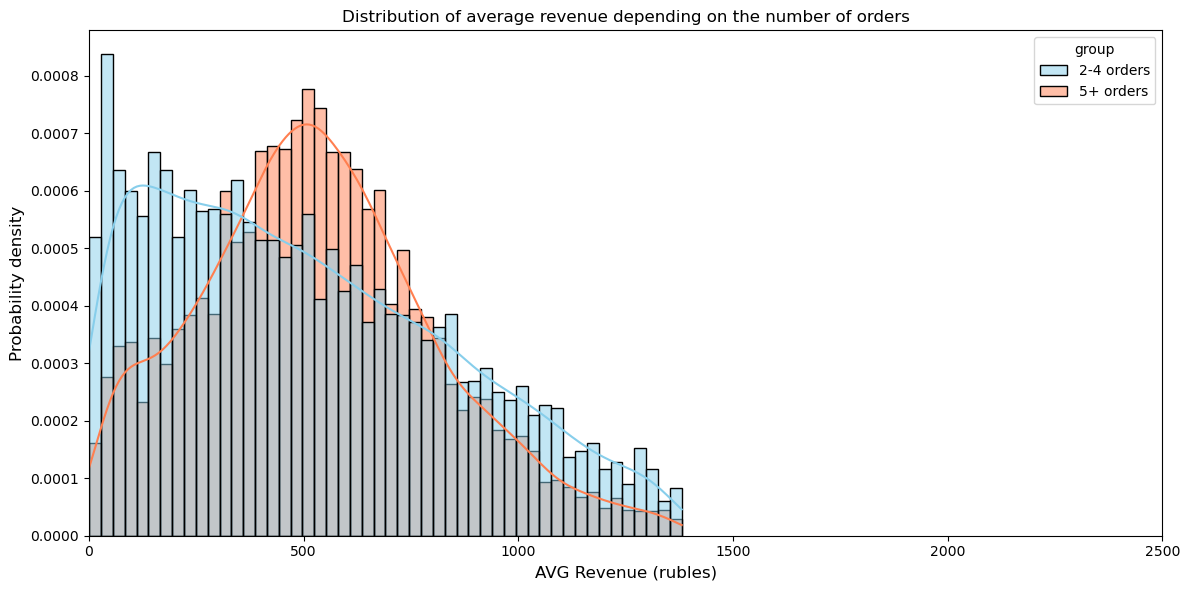

In [68]:
df_plot = user_profiles.copy()
df_plot['group'] = df_plot['total_orders'].apply(
    lambda x: '2-4 orders' if 2 <= x <= 4 else ('5+ orders' if x >= 5 else 'Else')
)

df_to_plot = df_plot[
    (df_plot['group'] == '2-4 orders') | 
    (df_plot['group'] == '5+ orders')
]


fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(
    data=df_to_plot,
    x='avg_revenue_rub',
    hue='group',  
    kde=True,
    bins=50,
    stat='density',
    palette=['skyblue', 'coral'],
    ax=ax
)

ax.set_xlim(0, 2500)
ax.set_xlabel('AVG Revenue (rubles)', fontsize=12)
ax.set_ylabel('Probability density', fontsize=12)
ax.set_title('Distribution of average revenue depending on the number of orders')

plt.tight_layout()
plt.show()

A normalized distribution analysis clearly reveals significant differences in average revenue per order between the two groups: users with 5+ orders have a distribution peak skewed to the right (approximately 400-500 rubles), while users with 2-4 orders are concentrated in a lower range (100-200 rubles). This indicates a direct link between repeat purchase frequency and willingness to pay more per order. Furthermore, the distribution in the 5+ user group is significantly broader, with a noticeable expansion in the 800-2500 ruble range, demonstrating the presence of a segment of high-spending, premium-oriented customers within the repeat purchase group.

**Task 4.2.3.** Let's analyze the impact of the average number of tickets per order on the likelihood of repeat purchases.

- We'll examine the distribution of users by the average number of tickets per order (avg_tickets_count) and describe the key observations.
- We'll divide users into several segments based on the average number of tickets per order:
- 1 to 2 tickets;
- 2 to 3 tickets;
- 3 to 5 tickets;
- 5 or more tickets.
- For each segment, we'll calculate the total number of users and the proportion of users who made repeat orders.
- We'll answer the following questions:
- How are users distributed across segments—evenly or concentrated?
- Are there any segments with an abnormally high or low rate of repeat purchases?

In [69]:
user_profiles['tickets_segment'] = pd.cut(
    user_profiles['avg_tickets_count'],
    bins=[0, 2, 3, 5, float('inf')],
    labels=['1-2 tickets', '2-3 tickets', '3-5 tickets', '5+ tickets'],
    right=False
)

segments_stats = user_profiles.groupby('tickets_segment').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).reset_index()
segments_stats.columns = ['segment', 'count', 'return_rate']
segments_stats['return_pct'] = segments_stats['return_rate'] * 100

print(segments_stats.to_string(index=False))

    segment  count  return_rate  return_pct
1-2 tickets   2386     0.511316   51.131601
2-3 tickets   9338     0.735061   73.506104
3-5 tickets   8186     0.561691   56.169069
 5+ tickets    489     0.167689   16.768916


If we consider more than 70% of customers who return to the platform to be abnormally high, then such customers are among those who buy 2-3 tickets, and the smallest number are among those who buy 5+ tickets.

### Studying the Timing of the First Order and Its Impact on Repeat Purchases

Let's examine the timing parameters associated with users' first orders:

- Day of the week of the first purchase;
- Lifetime since the first purchase;
- Average interval between purchases for users with repeat orders.

**Task 4.3.1.** Let's analyze how the day of the week the first purchase was made influences user behavior.

- Based on the date of the first order, identify the day of the week.
- For each day of the week, calculate the total number of users and the proportion of users who made repeat orders. Visualize the results.
- Answer the question: does the day of the week the first purchase was made influence the likelihood of a customer returning?

In [70]:
user_profiles['first_day_of_week'] = pd.to_datetime(user_profiles['first_order_dt']).dt.day_name()
user_profiles['first_day_of_week_num'] = pd.to_datetime(user_profiles['first_order_dt']).dt.dayofweek + 1

day_stats = user_profiles.groupby('first_day_of_week').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).reset_index()
day_stats.columns = ['day', 'count', 'return_rate']
day_stats['return_pct'] = day_stats['return_rate'] * 100


day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_stats['day'] = pd.Categorical(day_stats['day'], categories=day_order, ordered=True)
day_stats = day_stats.sort_values('day')

print(day_stats.to_string(index=False))

      day  count  return_rate  return_pct
   Monday   2763     0.639522   63.952226
  Tuesday   2975     0.630252   63.025210
Wednesday   2909     0.633207   63.320729
 Thursday   2933     0.607569   60.756904
   Friday   3063     0.611492   61.149200
 Saturday   3144     0.639631   63.963104
   Sunday   2612     0.617917   61.791730


In [71]:
user_profiles['lifetime_days'] = (user_profiles['last_order_dt'] - user_profiles['first_order_dt']).dt.days

# For customers with 1 order lifetime = 0
single_order = user_profiles[user_profiles['total_orders'] == 1]
repeat_order = user_profiles[user_profiles['total_orders'] > 1]

print(f"Customers with 1 order: {(single_order['lifetime_days'] == 0).sum():,}")
print(f"Customers with 2+ orders:")
print(f"Mean: {repeat_order['lifetime_days'].mean():.0f} days")
print(f"Median: {repeat_order['lifetime_days'].median():.0f} days")


Customers with 1 order: 7,635
Customers with 2+ orders:
Mean: 63 days
Median: 59 days


In [72]:
# Avg interval between orders
repeat_with_interval = user_profiles[user_profiles['avg_days_between_orders'].notna()]

print(f"Mean: {repeat_with_interval['avg_days_between_orders'].mean():.2f} days")
print(f"Median: {repeat_with_interval['avg_days_between_orders'].median():.2f} days")
print(f"Std: {repeat_with_interval['avg_days_between_orders'].std():.2f}")

Mean: 16.29 days
Median: 8.58 days
Std: 22.42


In [73]:
# Day of the first order
user_profiles['first_day_of_week'] = pd.to_datetime(user_profiles['first_order_dt']).dt.day_name()
user_profiles['first_day_num'] = pd.to_datetime(user_profiles['first_order_dt']).dt.dayofweek + 1

# Statistics per day of a week
day_analysis = user_profiles.groupby('first_day_of_week').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).reset_index()
day_analysis.columns = ['day', 'count', 'return_rate']
day_analysis['return_pct'] = day_analysis['return_rate'] * 100

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_analysis['day'] = pd.Categorical(day_analysis['day'], categories=day_order, ordered=True)
day_analysis = day_analysis.sort_values('day').reset_index(drop=True)


print(day_analysis.to_string(index=False))

print("=" * 40)

# Influence Analysis
max_day = day_analysis.loc[day_analysis['return_pct'].idxmax()]
min_day = day_analysis.loc[day_analysis['return_pct'].idxmin()]
diff = max_day['return_pct'] - min_day['return_pct']

print(f"More customers come back on: {max_day['day']} ({max_day['return_pct']:.2f}%)")
print(f"Less customers come back on: {min_day['day']} ({min_day['return_pct']:.2f}%)")

      day  count  return_rate  return_pct
   Monday   2763     0.639522   63.952226
  Tuesday   2975     0.630252   63.025210
Wednesday   2909     0.633207   63.320729
 Thursday   2933     0.607569   60.756904
   Friday   3063     0.611492   61.149200
 Saturday   3144     0.639631   63.963104
   Sunday   2612     0.617917   61.791730
More customers come back on: Saturday (63.96%)
Less customers come back on: Thursday (60.76%)


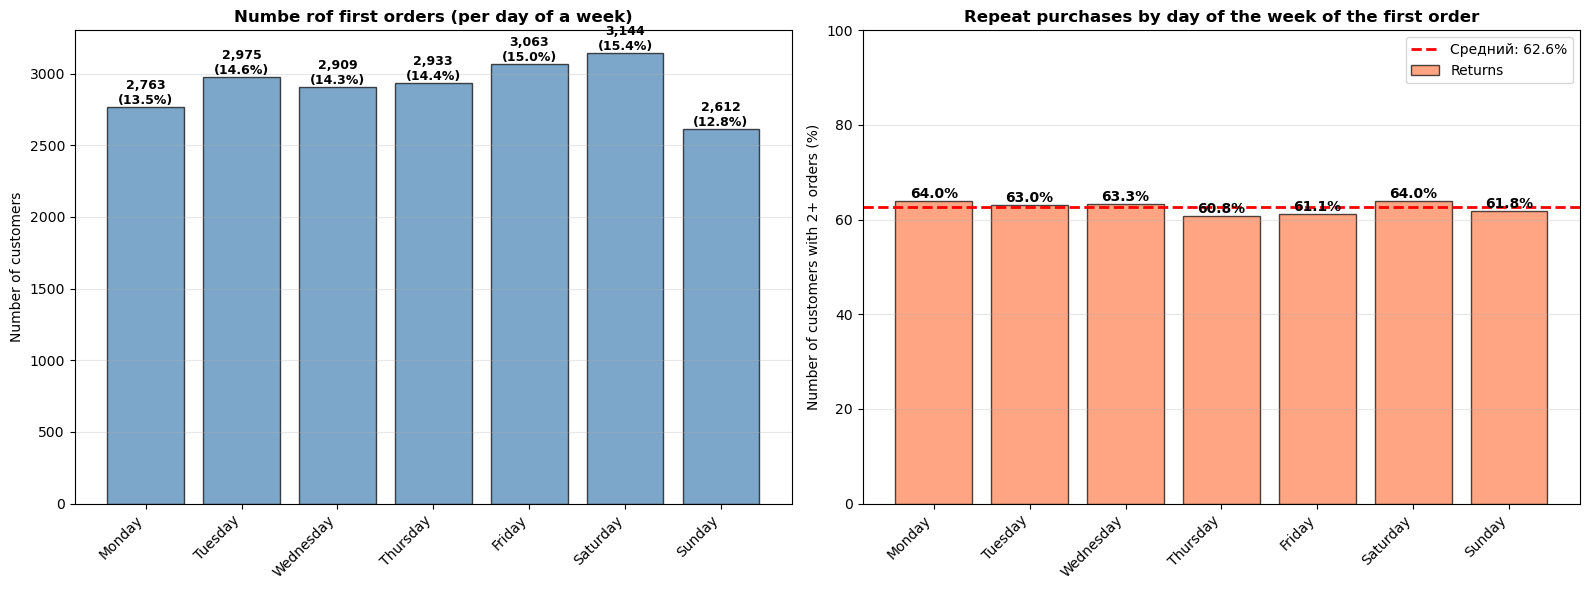

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x_pos = range(len(day_analysis))
avg_return = (user_profiles['total_orders'] >= 2).sum() / len(user_profiles) * 100

# Number of customers per day
axes[0].bar(x_pos, day_analysis['count'], color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Numbe rof first orders (per day of a week)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of customers')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(day_analysis['day'], rotation=45, ha='right')
axes[0].grid(alpha=0.3, axis='y')

for i, v in enumerate(day_analysis['count']):
    axes[0].text(i, v, f'{v:,}\n({v/len(user_profiles)*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=9)

# Доля возвратов по дням
axes[1].bar(x_pos, day_analysis['return_pct'], color='coral', alpha=0.7, edgecolor='black', label='Returns')
axes[1].axhline(avg_return, color='red', linestyle='--', linewidth=2, label=f'Средний: {avg_return:.1f}%')
axes[1].set_title('Repeat purchases by day of the week of the first order', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of customers with 2+ orders (%)')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(day_analysis['day'], rotation=45, ha='right')
axes[1].set_ylim([0, 100])
axes[1].grid(alpha=0.3, axis='y')
axes[1].legend()

for i, v in enumerate(day_analysis['return_pct']):
    axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

The highest number of first-time orders are placed on Saturdays, and the highest number of repeat purchases are also made on this day of the week. However, the overall rate of repeat purchases does not depend on the day of the week—for example, people are less likely to buy on Sundays, but the return rate to the platform is comparable to other days (around 61%).

**Task 4.3.2.** Let's study how the average interval between orders impacts customer retention.

- We'll calculate the average time between orders for two groups of users:
- those who placed 2-4 orders;
- those who placed 5 or more orders.
- We'll examine how the average interval between orders impacts the likelihood of repeat orders and draw conclusions.

In [75]:
user_profiles['avg_days_between_orders'] = user_profiles['avg_days_between_orders'].fillna(0)

# Statistics for the intervals between orders
print(f"Mean: {users_2_4['avg_days_between_orders'].mean():.2f} days")
print(f"Median: {users_2_4['avg_days_between_orders'].median():.2f} days")
print(f"Std: {users_2_4['avg_days_between_orders'].std():.2f}")

print("=" * 30)

print(f"Mean: {users_5_plus['avg_days_between_orders'].mean():.2f} days")
print(f"Median: {users_5_plus['avg_days_between_orders'].median():.2f} days")
print(f"Std: {users_5_plus['avg_days_between_orders'].std():.2f}")

Mean: 21.63 days
Median: 10.00 days
Std: 28.48
Mean: 9.90 days
Median: 8.12 days
Std: 7.77


In [76]:
# We create segments based on the interval between orders
user_profiles['interval_segment'] = pd.cut(
    user_profiles['avg_days_between_orders'],
    bins=[0, 7, 14, 30, float('inf')],
    labels=['Up to 7 days ', '7-14 days', '14-30 days', '30+ days'],
    right=False
)


interval_stats = user_profiles[user_profiles['interval_segment'].notna()].groupby('interval_segment').agg({
    'user_id': 'count',
    'is_two': 'mean',
    'total_orders': 'mean'
}).reset_index()
interval_stats.columns = ['segment', 'count', 'return_rate', 'avg_orders']
interval_stats['return_pct'] = interval_stats['return_rate'] * 100

print(interval_stats.to_string(index=False))

      segment  count  return_rate  avg_orders  return_pct
Up to 7 days   13298     0.429388    7.143104   42.938788
    7-14 days   2427     0.999176    8.927070   99.917594
   14-30 days   2525     0.996832    5.060198   99.683168
     30+ days   2149     0.982783    2.750116   98.278269


The LONGER the interval between orders, the higher the likelihood of a return. Those who order frequently and urgently (up to 7 days) often leave (42% return rate), while those who order rarely and systematically (7-30+ days) almost never leave (99% return rate). Therefore, it's not the frequency that matters, but the nature of the buyer (qualitative vs. quantitative).

### Correlation Analysis of Purchase Quantity and User Attributes

Let's examine which characteristics of the first order and user profile may be related to the number of purchases. For this, we use the universal correlation coefficient phi_k, which allows us to analyze both numerical and categorical attributes.

**Task 4.4.1**: Conducting Correlation Analysis:
- Calculate the correlation coefficient phi_k between user profile attributes and the number of orders (total_orders).
- Analyze the obtained results. If the obtained values ​​are close to zero, check the data dispersion in total_orders. This is possible when a single value predominates in the data: in this case, correlation analysis may reveal no relationship.
- Visualize the correlation results using a heat map.
- Answer the question: Which attributes are most closely related to the number of orders?


In [77]:
analysis_cols = [
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between_orders',
    'first_device',
    'first_region',
    'first_event_type',
    'first_service',
    'is_two',
    'is_five',
    'lifetime_days'
]

interval_cols = ['avg_revenue_rub', 'avg_tickets_count', 'avg_days_between_orders', 'lifetime_days', 'total_orders']

df = user_profiles.copy()

In [78]:
phik_df = df[analysis_cols + ['total_orders']].dropna()

phik_mat = phik_df.phik_matrix(interval_cols=interval_cols)
phik_with_total = phik_mat['total_orders'].drop(index='total_orders').sort_values(ascending=False)

phik_with_total

is_five                    0.636215
lifetime_days              0.618371
avg_tickets_count          0.339232
is_two                     0.319399
avg_revenue_rub            0.246542
avg_days_between_orders    0.166184
first_region               0.141774
first_service              0.037396
first_event_type           0.029803
first_device               0.015220
Name: total_orders, dtype: float64

In [79]:
# Make a division into segments due to the small value of most coefficients
df['order_segment'] = pd.cut(
    df['total_orders'],
    bins=[float('-inf'), 1, 4, float('inf')],
    labels=['1 order', '2-4 orders', '5+ orders'],
    include_lowest=True
)

seg_df = df[analysis_cols + ['order_segment']].dropna()

seg_phik_mat = seg_df.phik_matrix(interval_cols=['avg_revenue_rub','avg_tickets_count','avg_days_between_orders','lifetime_days'])

phik_with_segment = seg_phik_mat['order_segment'].drop(index='order_segment').sort_values(ascending=False)

phik_with_segment

is_two                     1.000000
is_five                    1.000000
lifetime_days              0.728988
avg_tickets_count          0.578161
avg_days_between_orders    0.529186
avg_revenue_rub            0.320971
first_region               0.132220
first_service              0.102261
first_event_type           0.055095
first_device               0.021138
Name: order_segment, dtype: float64

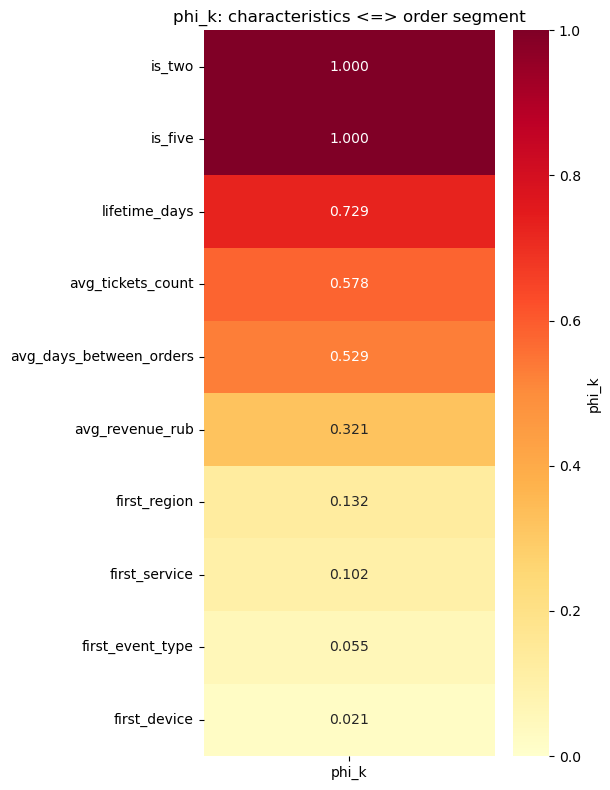

In [80]:
plt.figure(figsize=(6, 8))
sns.heatmap(
    phik_with_segment.to_frame('phi_k'),
    annot=True, fmt='.3f',
    vmin=0, vmax=1,
    cmap='YlOrRd',
    cbar_kws={'label': 'phi_k'}
)
plt.title('phi_k: characteristics <=> order segment')
plt.tight_layout()
plt.show();

Initial analysis revealed that the total_orders variable exhibits a pronounced imbalance: a significant proportion of users placed only one order. This data structure leads to underestimated correlations and makes it difficult to identify stable relationships.

Phi_k analysis revealed that the following characteristics have the strongest correlation with the order segment:

- lifetime_days — the strongest correlation factor: The duration of user activity is significantly related to the number of orders: users with a longer lifetime are significantly more likely to fall into segments with repeat and multiple purchases.

- avg_tickets_count — a moderately strong correlation: Users who purchase more tickets per order on average are more likely to belong to segments with a higher number of orders, reflecting the scale and regularity of consumption.

- avg_days_between_orders — a significant time characteristic: Purchase frequency (intervals between orders) varies across segments and is an important behavioral indicator of repeat purchases.

Therefore, for analyzing and predicting repeat orders, lifecycle metrics and purchasing behavior patterns are more valuable than the characteristics of the user's first contact with the platform.

## SUMMARY AND RECOMMENDATIONS

**1) Data and Preparation**

The project used data on Yandex Afisha user orders and attributes of the first order (device type, region, event type, ticket operator, and several others), as well as financial and quantitative characteristics of the orders.

Before analysis, the data was prepared:

* Data type conversions were performed to ensure accurate calculations and save memory;
* Revenue was converted to a single currency (tenge → rubles) and the result was saved in a separate column;
* Abnormal revenue values ​​(including incorrect/abnormal values) and rare outliers in the number of tickets (for example, values ​​above thresholds that occur in an extremely small proportion of observations) were removed;
* A total of 8,954 rows (~3.1%) were removed to reduce the impact of outliers on the conclusions.

**2) Key Analysis Results**

* Sample: 20,271 users.
* Average revenue per order: ~520 rubles.
* Average number of tickets per order: 2.75.
* Average interval between orders: 16.04 days.
* Share of users with 2+ orders (returns to the platform): 13,308 (62%).
* Share of users with 5+ orders: 6,251 (29.00%).
* Distribution by number of orders is unbalanced: a significant proportion of users are "single buyers" (approximately 38% with 1 order).

**What characteristics of the first order are associated with returns?**

By type of first event, customer returns are higher for:

* theaters - 64.52%
* exhibitions - 63.21%
* concerts - 62.87%
Lower rates for sports and Christmas tree events (~55-58%).

The difference by device is small but noticeable:

* Desktop — 64.88%
* Mobile — 61.30%

There are differences by region and ticket operator (for example, top regions ~55-67%, top operators ~59-66%), but on average, this is more of a "secondary factor" compared to user behavior.

**How ​​is average revenue and number of tickets related to the likelihood of repeat purchases?**

* Average revenue per order does not increase with repeat customer retention. This means that a high first order alone does not guarantee retention. The number of tickets in the first order has a stronger and nonlinear impact (segments by average number of tickets—2-3 tickets—have the highest repeat purchase rate: 73.98%). 5+ tickets often resemble a one-time group/event purchase, while 2-3 tickets resemble a stable consumer pattern.

**Time Characteristics and Retention**

* Differences by day of week are moderate:

* Maximum return: Saturday - 63.7%
* Minimum: Friday - 60.7%
Overall, the day of week has an impact, but it doesn't appear to be the primary driver.

**3) Recommendations for the Client**

1. Focus on behavioral segments, not the "context" of the first order: For retention and revenue growth, the key levers are user lifetime value, regularity, and the "scale" of purchases (tickets), not device/region/event type. Customer behavior over time and the number of tickets purchased are more important in explaining repeat purchases than their demographics or initial service choice. A marketing strategy should focus not on increasing the first order amount, but on creating repeat purchase habits through mechanics that encourage regular, small orders.

2. Priority segment for increasing repeat purchases: "2-3 tickets": This is the highest retention group (around 74%). It's worth either retaining them with personalized recommendations and early access, or converting them into 5+ orders through soft mechanics (reminders, selections, interest calendars, subscriptions/packages).

3. Risk segment: "5+ tickets" - low retention (~18.5%). These are most likely one-time group purchases. This requires different mechanics, such as dedicated communication from the "organizer" (event management, repeat events, similar events for a company/family), and "buy again" offers not as an individual visitor, but as a "group buyer."

4. Don't overestimate average revenue as a retention metric: Higher checks for "one-time" users indicate that the goal is not to increase the check but to create a habit of repeat purchases.

5. First-Order Funnel: Strengthen High-Return Categories: Theaters/exhibitions/concerts offer a higher chance of return—it makes sense to use them as “entry categories” in marketing and onboarding (and similar recommendations after the first purchase).